In [6]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy.integrate as integrate

%matplotlib inline

In [7]:
# QuTiP Hamiltonian functions

def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
    return Qobj(m)

def Hc(Ec, Ej, N, ng):
    """
    Reutrn the charging term of the charge qubit hamiltonian as a Qobj instance
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) 
    
    return Qobj(m)

def Hj(Ec, Ej, N, ng):
    """
    Reutrn the charging term of the charge qubit hamiltonian as a Qobj instance
    """
    
    m = 0.5 * Ej * (np.diag(-np.ones(2*N), 1) + np.diag(-np.ones(2*N), -1))
    
    return Qobj(m)




In [8]:
# Plotting functions

def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    for n in range(len(energies[0,:])):
        axes[0].plot(ng_vec, energies[:,n])
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r'$n_g$', fontsize=18)
    axes[0].set_ylabel(r'$E_n$', fontsize=18)

    for n in range(len(energies[0,:])):
        axes[1].plot(ng_vec, (energies[:,n]-energies[:,0]))
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r'$n_g$', fontsize=18)
    axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=18)
    return fig, axes

def visualize_dynamics(result, ylabel):
    """
    Plot the evolution of the expectation values stored in result.
    """
    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(result.times, result.expect[0])

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(r'$t$', fontsize=16)

In [18]:
# EJ Pulsing

def EJ_tanh_pulse(t, P0, R0, T):
    return (1-P0*(1+np.tanh(-R0+(t/T)*2*R0))/2.0)

# Time depenedent part (drive)
def Hd_coeff(t,args):
    Percentage=args['Percentage']
    Range=args['Range']
    T=args['T']
    return EJ_tanh_pulse(t, Percentage, Range, T)

In [31]:
# Function for plottting the overlap between the original and the first excited state

def calculate_overlap(t, N, Ec, Ej, ng, T, P0, R0, states):
    Points=3000

    ng_vec = np.linspace(-1, 1, 200)
    energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies() for ng in ng_vec])
    evals, ekets = hamiltonian(Ec, Ej, N, ng).eigenstates()
    Htot = [Hc(Ec,Ej,N,ng), [Hj(Ec,Ej,N,ng), Hd_coeff]]
    psi0=ekets[0]
    evalsf, eketsf = hamiltonian(Ec, Ej*EJ_tanh_pulse(T, P0, R0, T), N, ng).eigenstates()
    output = sesolve(Htot, psi0, t, args={'Percentage': P0, 'Range': R0,'T':T})

    overlap_list = []
    for state in states:
        Ovrlp=np.zeros(Points)


        if state < 0:
            for n in range(0,Points):
                Ovrlp[n]=np.abs(psi0.dag().overlap(output.states[n]))**2
        else:
            for n in range(0,Points):
                Ovrlp[n]=np.abs(eketsf[state].dag().overlap(output.states[n]))**2

        overlap_list.append(Ovrlp)

    return overlap_list

        

    

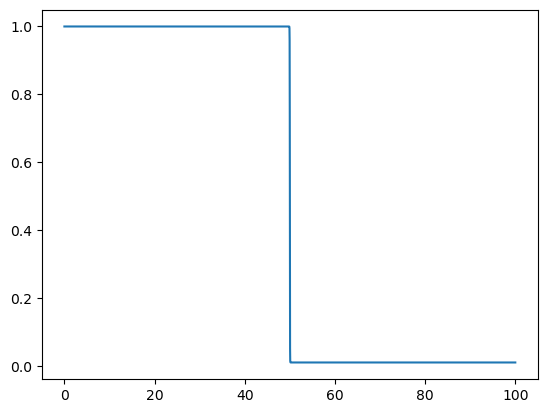

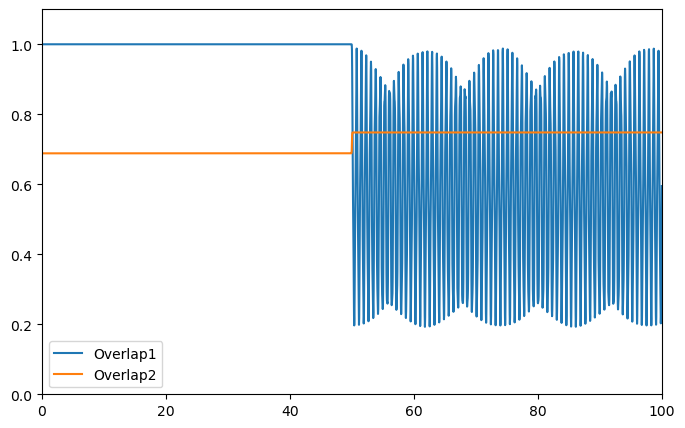

In [33]:
N = 10
Ec = 1.0
Ej = 50.0
ng=0.5
T=100.0
Points=3000
P0=0.99
R0=500*np.pi

tlist = np.linspace(0, T, Points)
plt.plot(tlist, EJ_tanh_pulse(tlist, P0, R0, T))
plt.show()

Ovrlps = calculate_overlap(tlist, N, Ec, Ej, ng, T, P0, R0, states = [-1, 0])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, Ovrlps[0], label="Overlap1")
ax.plot(tlist, Ovrlps[1], label="Overlap2")
ax.legend()
ax.set_xlim([0,T])
ax.set_ylim([0.0, 1.1])
plt.show()